In [1]:
import tensorflow as tf

print(tf.__version__)

2.0.0


### Transformer 模型的核心思想是自注意力机制（self-attention）
能注意输入序列的不同位置以计算该序列的表示的能力。Transformer 创建了多层自注意力层（self-attetion layers）组成的堆栈，下文的按比缩放的点积注意力（Scaled dot product attention）和多头注意力（Multi-head attention）部分对此进行了说明。

一个 transformer 模型用自注意力层而非 RNNs 或 CNNs 来处理变长的输入。
`这种通用架构有一系列的优势：`

1、它不对数据间的时间/空间关系做任何假设。这是处理一组对象（objects）的理想选择（例如，星际争霸单位（StarCraft units））。
2、层输出可以并行计算，而非像 RNN 这样的序列计算。
3、远距离项可以影响彼此的输出，而无需经过许多 RNN 步骤或卷积层（例如，参见场景记忆 Transformer（Scene Memory Transformer））
它能学习长距离的依赖。在许多序列任务中，这是一项挑战。

`该架构的缺点是：`

1、对于时间序列，一个单位时间的输出是从整个历史记录计算的，而非仅从输入和当前的隐含状态计算得到。这可能效率较低。
2、如果输入确实有时间/空间的关系，像文本，则必须加入一些`位置编码`，否则模型将有效地看到一堆单词。

#### 重点
1、位置向量编码的含义

2、和seq2seq的区别

3、Q,K,V的设计（QKV图形）

4、从attention谈transformer本质

### 以下代码用来实现经典的编码器－解码器代码，并使用 cmn_eng　2.2w条中英文翻译数据，作为实例
如果希望更详细的解读，强烈推荐阅读：https://zhuanlan.zhihu.com/p/28054589
https://leovan.me/cn/2018/10/seq2seq-and-attention-machanism/

In [2]:
!pip install sklearn

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


In [3]:
import tensorflow as tf
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

# 修复中文显示问题
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
print(tf.__version__)

# 判断是否gpu可用,如果可用设置gpu使用显存
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

2.0.0


In [5]:
import unicodedata
import re
import numpy as np
import os
import io
import time

In [6]:
with open('./data/ch_en.txt', 'r', encoding='utf-8') as f:
    contexts = f.readlines()
contexts[10]

'I met Lao Wang as soon as I went out of the door.\t我一出门就碰上老王了。\n'

In [7]:
def data_pro(contexts):
    processed_contexts_en = []
    processed_contexts_ch = []
    for line in contexts:
        en, ch = re.split(r'\t', line.strip(), 1)
        # 如果句子过长，则跳过此句
#         if len(ch) > 100:
#             continue
#         print(en, ch)
        en = re.sub(r'([\?\.\!\,¿])', r' \1', en)
#         print(en)
        en = re.sub(r'\s+', ' ', en)
        ch = re.sub(r'\s+', ' ', ch)
        en = re.sub(r'[^a-zA-Z\?\.\!\,。？！，、¿]+', r' ', en)
        ch = re.sub(r'[^a-zA-Z\?\.\!\,。？！，、¿\u4e00-\u9fa5]+', r' ', ch)
        en = '<start> ' + en[:200] + ' <end>'
        ch = '<start> ' + ' '.join([i for i in ch[:100]]) + ' <end>'
        
        processed_contexts_en.append(en)
        processed_contexts_ch.append(ch)
    
    return processed_contexts_en, processed_contexts_ch


processed_contexts_en, processed_contexts_ch = data_pro(contexts)

In [8]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(30000,
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [10]:
def load_dataset():
    # 创建清理过的输入输出对
    input_tensor, inp_lang_tokenizer = tokenize(processed_contexts_en)
    target_tensor, targ_lang_tokenizer = tokenize(processed_contexts_ch)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [11]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset()
input_tensor[-1], target_tensor[-1]
print('inp_lang词典大小', len(inp_lang.index_word))
inp_lang.texts_to_sequences(['<start> hello world <end>', 'head of'])
targ_lang.texts_to_sequences(['<start> 你 好 世 界 <end>', '你 好']), targ_lang.index_word[1]

inp_lang词典大小 105877


([[3, 19, 90, 249, 296, 4], [19, 90]], '的')

In [12]:
# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [13]:
# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.15)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

255000 255000 45001 45001


In [14]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [15]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
3 ----> <start>
15 ----> you
341 ----> cannot
2192 ----> excuse
4124 ----> yourselves
33 ----> from
27753 ----> wrongful
876 ----> thinking
90 ----> any
57 ----> more
5 ----> ,
47 ----> my
212 ----> children
2 ----> .
4 ----> <end>

Target Language; index to word mapping
3 ----> <start>
19 ----> 你
13 ----> 不
24 ----> 要
325 ----> 再
20 ----> 为
50 ----> 自
169 ----> 己
1 ----> 的
13 ----> 不
793 ----> 善
1 ----> 的
504 ----> 思
123 ----> 想
464 ----> 找
1044 ----> 借
276 ----> 口
11 ----> 了
2 ----> ，
9 ----> 我
1 ----> 的
354 ----> 孩
44 ----> 子
5 ----> 。
4 ----> <end>


In [16]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 256
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [17]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([256, 53]), TensorShape([256, 61]))

#### self-attention机制的transformer实现:
1、编码器:是由 N=6 个相同的网络层构成，每层中包含两个子层。第一层为一个 Multi-Head Self-Attention 层，第二层为一个 Position-Wise 全链接的前馈神经网络。每一层再应用一个残差连接 (Residual Connection) 7 和一个层标准化 (Layer Normalization) 8。则每一层的输出为 Layer(x + sublayer(x))，其中`sublayer(x)`为子层本身的函数实现。为了实现 为了实现残差连接，模型中所有的子层包括 Embedding 层的输出维度均为 dmodel=512。

２、解码器: 也是由 N=6 个相同的网络层构成，但每层中包含三个子层，增加的第三层用于处理编码器的输出。同编码器一样，每一层应用一个残差连接和一个层标准化。除此之外，解码器对 Self-Attention 层进行了修改，确保对于位置  的预测仅依赖于位置在  之前的输出。

#### 重点的几个部分：
① self_attention层(Multi-head attention)组件, Attention(Q, K, V) = softmax({Q . trans(K) /sqrt(d_k)) V

② feed_forword层组件
如图：
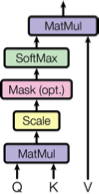

In [18]:
# 计算mask矩阵
def create_padding_mask(seq):
    """
    计算sequence的mask
    """
    mask = tf.not_equal(seq, 0)

    return tf.cast(mask, tf.float32)

In [19]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=23, shape=(3, 5), dtype=float32, numpy=
array([[1., 1., 0., 0., 1.],
       [1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1.]], dtype=float32)>

In [20]:
# 生成一个下三角矩阵：
tf.linalg.band_part(tf.ones((3,3)), -1, 0)

<tf.Tensor: id=29, shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>

In [21]:
# 创建一个用来解码器训练用的 前瞻遮掩　(look_ahead_mask)，用于遮挡一个序列中的后续标记，因为用来训练时，只能看见前面的序列，看不见后面
def create_look_ahead_mask(size):
    ahead_mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    
    return ahead_mask

In [22]:
create_look_ahead_mask(5)

<tf.Tensor: id=35, shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

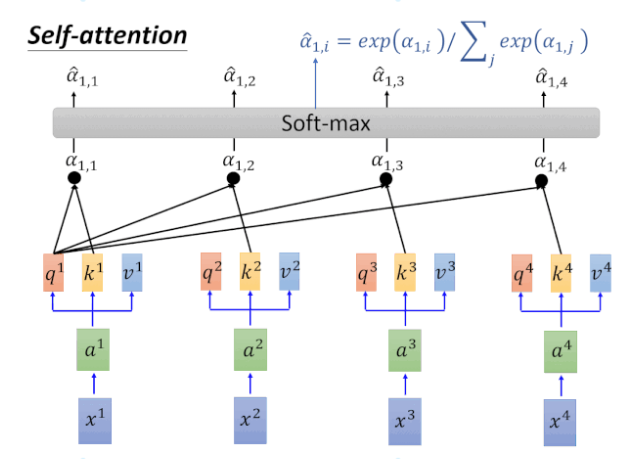

#### 这里维度信息比较复杂，对于多头，Q、K、V矩阵，维度应该为 (batch_size, heads_num, seq_lenth, dk), dk=d_{model} / heads_num

In [23]:

def compute_scaled_dot_product_attention(q, k, v, mask=None):
    """
    q, k, v都是经过计算后的向量
    q: (batch_size, num_heads, seq_len, depth_q)
    k: (batch_size, num_heads, seq_len, depth_k)
    v: (batch_size, num_heads, seq_len, depth_v)
    mask: (batch_size, seq_len)
    
    """
    # Q .transpose(K)
    # tf.matmul()中的transpose_b默认从最后两位进行转置(tf.transpose(x, perm=[0,1,3,2]))，即得(batch_size, num_heads, seq_len, seq_len)
    mat_qk = tf.matmul(q, k, transpose_b=True)
    # sqrt(dk)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)  # depth_k
    scaled_attention_logits = mat_qk / tf.math.sqrt(dk)    # (batch_size, num_heads, seq_len, seq_len)
    # 加上mask
    if mask is not None:
        # 先将mask转换 mask: (batch_size, seq_len) --> (batch_size, 1 , 1, seq_len)
        scaled_attention_logits *= mask[:, tf.newaxis, tf.newaxis, :]

    # 计算权重
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) # batch_size, num_heads, seq_len, seq_len
    # 计算value: (bz, nh, sql, sql) @ (bz, nh, sql, sql) -->　(bz, nh, sql, sql)
    output = tf.matmul(attention_weights, v)    # 然后将多个头的output拼接起来
    
    return output, attention_weights

#### 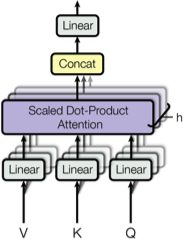

In [24]:
# 定义　MultiHeadAttention:参数: d_model, num_heads
# multi_head_attention输入为 inputs 维度 (batch_size, seq_len, head_out)

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        # 输出维度除以head数应为整数
        assert self.d_model % self.num_heads == 0
        # 单个head的维度 (batch, seq_len, self.depth)
        self.depth = self.d_model // self.num_heads
        
        # 定义Q, K, V注意力矩阵,同时定义多头，然后使用reshape
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        # 线性层
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x):
        """
        x : (batch_size, seq_len, d_model)
        """
        x = tf.reshape(x, (x.shape[0], -1, x.shape[1], self.depth))
        
        return x
    
    def call(self,inputs, mask):
        q = self.wq(inputs)    # (batch_size, seq_len, d_model)
        k = self.wk(inputs)
        v = self.wv(inputs)
        
        # 拆分成多头
        q = self.split_heads(q)    # (batch_size, num_heads, seq_len, self.depth)
        k = self.split_heads(k)
        v = self.split_heads(v)
        
        #(bz, nh, sql, sql)
        scaled_attention, attention_weights = compute_scaled_dot_product_attention(q, k, v, mask) 
        
        concat_attention = tf.reshape(scaled_attention, (scaled_attention.shape[0], -1, self.d_model))
        # 经过 linear层
        output = self.dense(concat_attention)    # (batch_size, seq_len, d_model)
        print(output.shape)

        return output, attention_weights

In [25]:
temp_mha = MultiHeadAttention(num_heads=8, d_model=512)
y = tf.random.uniform((2, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, mask=None)
out.shape, attn.shape

(2, 60, 512)


(TensorShape([2, 60, 512]), TensorShape([2, 8, 60, 60]))

#### 本编码器采用 Bahdanau 注意力
p(y_i | y_1,..., y_{i-1}, x) = g(y_{i-1}, s_i, c_i)

s_i = f (s_{i-1}, y_{i-1}, c_i)    # 即 s_i与 s_{i-1} , y_{i-1}, c_i 有关, c_i 是 attention 计算得来


In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.enc_units = enc_units
        self.batch_sz = batch_sz
        # 返回隐状态 和 整个输出序列
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True, return_state=True, 
                                       recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        # x形状为 (batch_size, seq_len)
        # hidden 为初始化向量,形状为 (batch_size, units_dim)
        em = self.embedding_dim(x)
        output, state = self.gru(em, initial_state = hidden)
        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 初始化一个样本输入隐向量
sample_hidden = encoder.initialize_hidden_state()
print(sample_hidden)

sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('input shape: (batch size, sequence length) {}'.format(example_input_batch.shape))
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

In [ ]:
# attention 实现的是输入两个向量，输出　上下文向量　和　权重，其中权重主要是为了后续 方便　可视化使用,那么，BahdanauAttention中：
# Ci = reduce_sum(α * Hs)，　αij = exp(eij) / reduce_sum(exp(eij)), eij = v.tanh(w.s + w.h)
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        """
        # 初始化需要训练的参数 eij = v.tanh(w.s + w.h)，乘相当于dense操作
        """
        super(BahdanauAttention, self).__init__()
        self.Ws = tf.keras.layers.Dense(units)
        self.Wh = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        """
        输入: query, values,即S_t-1, hidden_ts
        输出: context_vec, attention_weights
        """
        # 这里根据使用方法，query 是 Si中的一个
        query = tf.expand_dims(query, axis=1)
        # eij = v.tanh(w.s + w.h) 这个式子比较特别，需要使用广播机制
        # w . S -> （batch_size, 1, units）, W . h -> (batch_size, seq_len, units)满足广播机制，且 score —> (batch_size, seq_len, 1)
        score = self.V(tf.tanh(self.Ws(query) + self.Wh(values)))
        # 计算 权重 attention_weight 形状 (batch_size, seq_len, 1)，在 seqence 方向上 转换概率值，所以 axis = 1
        attention_weights = tf.nn.softmax(score, axis=1)
        # 计算 content_vector,沿着 axis=1的方向求和
        context_vec = tf.reduce_sum(attention_weights * values, axis=1)
    
        return context_vec, attention_weights

In [ ]:
# attention 实现的是输入两个向量，输出　上下文向量　和　权重，其中权重主要是为了后续 方便　可视化使用,那么，BahdanauAttention中：
# Ci = reduce_sum(α * Hs)，　αij = exp(eij) / reduce_sum(exp(eij)), eij = v.tanh(w.s + w.h)
class BahdanauAttention2(tf.keras.layers.Layer):
    def __init__(self, units):
        """
        # 初始化需要训练的参数 eij = v.tanh(w.s + w.h)，乘相当于dense操作
        """
        super(BahdanauAttention2, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        # 注意这里使用了 build 方法,其主要用于根据input_shape创建 layer的Variable
        self.Ws = tf.Variable(tf.random.normal(shape=(input_shape[-1],units),stddev=0.01,mean=0,dtype=tf.float32))
        self.Wh = tf.Variable(tf.random.normal(shape=(input_shape[-1],units),stddev=0.01,mean=0,dtype=tf.float32))
        self.V = tf.Variable(tf.random.normal(shape=(input_shape[-1],1),stddev=0.01,mean=0,dtype=tf.float32))

    def call(self, query, values):
        """
        输入: query, values,即S_t-1, hidden_ts
        输出: context_vec, attention_weights
        """
        query = tf.expand_dims(query, axis=1)
        score = (tf.tanh(query @ self.Ws + values @ self.Wh)) @ self.V
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vec = tf.reduce_sum(attention_weights * values, axis=1)

        return context_vec, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

print(attention_weights[0])  # 可以看出，没有经过训练的网络，权重参数是比较均衡的

In [ ]:
# decoder 输入和输出是什么？ decoder是逐个解码，所以，输入是 x -> (batch_size, 1), decoder侧的隐向量 hidden -> (batch_size, dec_units)
# 输出是 下一个状态的隐向量 state 及 output,以及为了方便打印的 attention_weights

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size    # 词表大小
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)    # 词嵌入维度
        self.dec_units = dec_units    # 解码器 gru的矩阵的维度，即 hidden_size大小
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, 
                                       return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        # 逐个计算 x,hidden,enc_output计算得到的权重计算后的 context_vec 和 attention_weight
        context_vec, attention_weights = self.attention(hidden, enc_output)
        # x的维度是 batch_size * 1，经过 embedding 后的维度为 (batch_sz, 1, embedding_size)
        x = self.embedding(x)
        # 拼接 x 和 context_vec，得到 (batch_size, 1, hidden_size+embedding_dim)
        x = tf.concat([tf.expand_dims(context_vec, 1), x], axis=-1)
        # 然后将 x 输入到 gru 中
        output, state = self.gru(x, initial_state=hidden)
        # # dense输入可以为2维,也可以为3维，dense会自动在 time_step维度上展开,所以考虑输出后的维度为2维，先进行维度转换
        output = tf.reshape(output, (-1, output.shape[2]))
        # 输出形状 (batch_size, vocab_size)
        x = self.fc(output)
        
        return x, state, attention_weights

In [ ]:
# 简单测试
decoder = Decoder(vocab_tar_size, embedding_dim, units)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

### 定义优化器和损失函数

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    # 计算mask
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

# loss的计算方式

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
tf.train.Checkpoint()

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    # encoder的最后输出隐状态作为 decoder 初始输入隐状态
    dec_hidden = enc_hidden
    # 使用 <start> 做初始解码输入
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # 教师强制 - 将目标词作为下一个输入
    for t in range(1, targ.shape[1]):    # 逐个输入
      # 将编码器输出 （enc_output） 传送至解码器
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # 使用教师强制，预测阶段正常解码应该用 predictions 作为下一个 time_step 的输入
      dec_input = tf.expand_dims(targ[:, t], 1)
  # 平均 batch_loss
  batch_loss = (loss / int(targ.shape[0]))
  # 总的可训练参数:
  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # 每 2 个周期（epoch），保存（检查点）一次模型
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

### 翻译
评估函数类似于训练循环，不同之处在于在这里我们不使用 `教师强制`。每个时间步的解码器输入是其先前的预测、隐藏层状态和编码器输出。
当模型预测 结束标记 时停止预测。
存储 每个时间步的注意力权重。
请注意：对于一个输入，编码器输出仅计算一次。

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    inputs = inp_lang.texts_to_sequences([sentence])
    print('inputs', inputs)
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# 注意力权重制图函数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### 恢复最新的检查点并验证

In [ ]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
translate('<start> spreading the cost of their work over all users . <end>')

In [ ]:
translate('<start> The House of Representatives approved a similar package earlier this month ! <end>')

In [ ]:
translate('<start> Many companies seek reassurance that all is well by installing cyber-security tools to monitor employees ! <end>')